In [1]:
import sys
sys.path.insert(0,'..')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from timeit import default_timer as timer
from pygam import LinearGAM, GAM, s, f
from sklearn.utils import resample
from matrixMath import Knotilus
import matplotlib.pyplot as plt
from pyearth import Earth
import pandas as pd
import numpy as np

In [2]:
def modelComp_boot(data, iters, split, verbose=False):
    fullVariable = np.array(data[0])
    fullTarget   = np.array(data[1])

    results = []

    for i in range(iters):
        if verbose:
            print('Iteration:', i)

        trainIndices = resample(np.arange(fullVariable.shape[0]), replace=True, n_samples=int(fullVariable.shape[0] * split))
        testIndices = np.array([ind for ind in np.arange(fullVariable.shape[0]) if ind not in trainIndices])
        X_train = fullVariable[trainIndices]
        y_train = fullTarget[trainIndices]
        X_test  = fullVariable[testIndices]
        y_test  = fullTarget[testIndices]

        if verbose:
            print('Running', method)
        
        start = timer()
        model = Knotilus(X_train, y_train)
        model = model.fit(numKnots='auto')
        end = timer()

        model.errFunc  = model.RMSE
        model.variable = X_test
        model.target   = y_test

        test_rmse = model.error(model.knotLoc)

        result = {
            'iteration' : i,
            'method' : 'Knotilus',
            'test-rmse' : test_rmse,
            'time' : end-start,
            'model' : model
        }

        results.append(result)

        start = timer()
        lams = np.random.rand(100, 1)
        lams = lams * 1 - .5
        lams = np.exp(lams)
        model = LinearGAM(verbose=False).gridsearch(np.array(X_train).reshape(-1, 1), y_train, lam=lams)
        end = timer()

        test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

        result = {
            'iteration' : i,
            'method' : 'GAM',
            'test-rmse' : test_rmse,
            'time' : end-start,
            'model' : model
        }

        results.append(result)

        start = timer()
        model = Earth()
        model.fit(X_train, y_train)
        end = timer()

        test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

        result = {
            'iteration' : i,
            'method' : 'MARS',
            'test-rmse' : test_rmse,
            'time' : end-start,
            'model' : model
        }

        results.append(result)

    return results

In [3]:
df = pd.read_csv('../data/us_covid19_daily.csv')
df['deathIncrease'] = df['deathIncrease'].astype(int)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['unixTime'] = df['date'].astype(int) / 10**9
df = df[['unixTime', 'deathIncrease']]

ss  = MinMaxScaler()
foo = ss.fit_transform(df)
covid = pd.DataFrame(foo)

df = pd.read_csv('../data/Bike-Sharing-Dataset/day.csv')
df = df[['temp', 'cnt']]

ss  = MinMaxScaler()
foo = ss.fit_transform(df)
bike = pd.DataFrame(foo)

df = pd.read_csv('../data/pw_data3_1000.csv')
ss  = MinMaxScaler()
foo = ss.fit_transform(df)
synthetic_500 = pd.DataFrame(foo)

df = pd.read_csv('../data/pw_data3_5000.csv')
ss  = MinMaxScaler()
foo = ss.fit_transform(df)
synthetic_5k = pd.DataFrame(foo)

In [4]:
datasets = [
    {'name' : 'Covid', 'data': covid},
    {'name' : 'Bike', 'data': bike},
    {'name' : 'Synthetic_500', 'data': synthetic_500},
    {'name' : 'Synthetic_5k', 'data': synthetic_5k}
]

In [5]:
for dataset in datasets:
    dataset['results'] = modelComp_boot(dataset['data'], 100, .9)

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |#####################

In [6]:
for dataset in datasets:
    bestResults = {}
    for result in dataset['results']:
        if result['method'] not in bestResults or result['test-rmse'] < bestResults[result['method']]['test-rmse']:
           bestResults[result['method']] = result
    dataset['bestResults'] = bestResults

In [7]:
for dataset in datasets:
    df_all = pd.DataFrame.from_dict(dataset['results'])
    df_best = pd.DataFrame.from_dict(dataset['bestResults'])

    df_all.to_csv(f"../data/results/model_comp_{dataset['name']}_all.csv", index=False)
    df_best.to_csv(f"../data/results/model_comp_{dataset['name']}_best.csv", index=False)

In [11]:
df_best

Knotilus  \
iteration                                              68   
method                                           Knotilus   
test-rmse                                        0.088704   
time                                            12.337983   
model      <matrixMath.Knotilus object at 0x7f772c29a550>   

                                                         GAM      MARS  
iteration                                                 64        10  
method                                                   GAM      MARS  
test-rmse                                           0.089181  0.090359  
time                                                4.592949  0.343846  
model      LinearGAM(callbacks=[Deviance(), Diffs()], fit...   Earth()

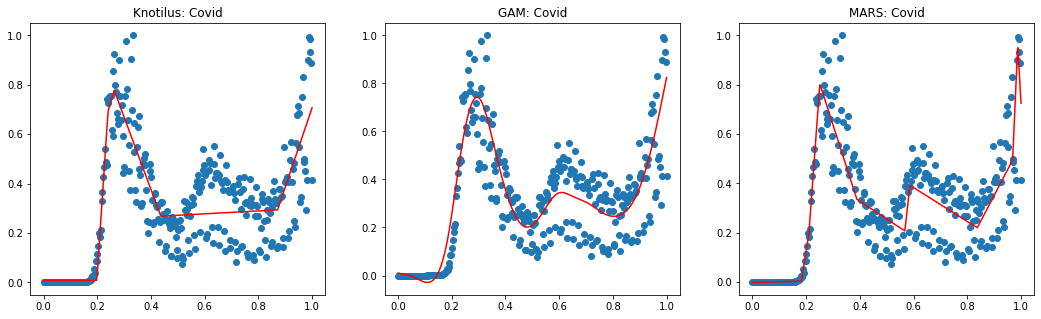

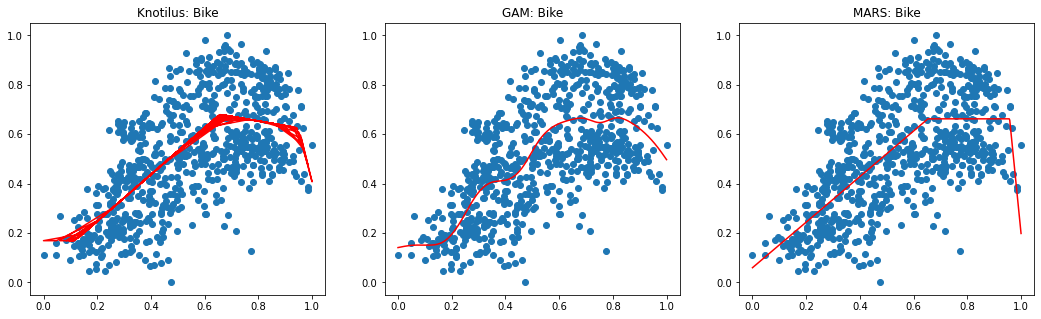

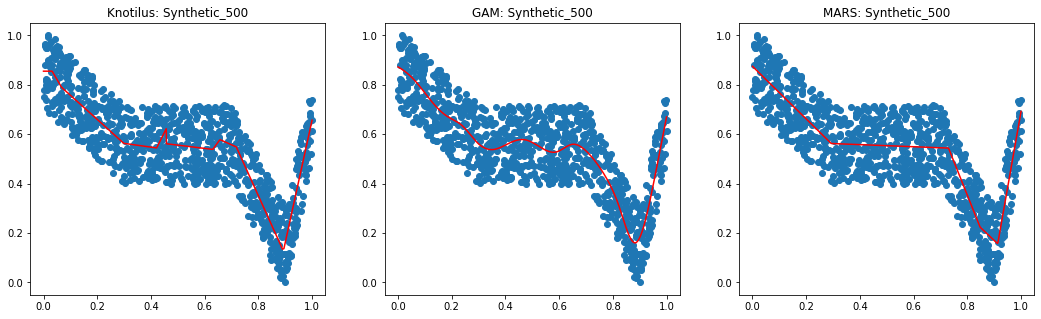

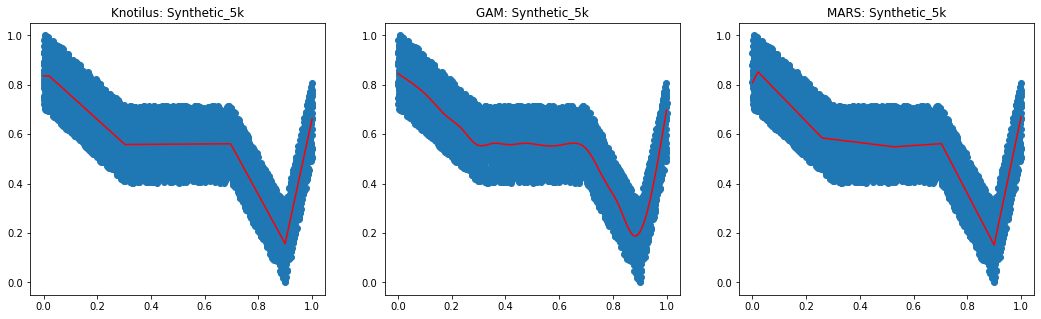

In [13]:
for dataset in datasets:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

    model = dataset['bestResults']['Knotilus']['model']
    model.errFunc  = model.SSE
    model.variable = np.array(dataset['data'][0])
    model.target   = np.array(dataset['data'][1])

    test_rmse = model.error(model.knotLoc)

    model = dataset['bestResults']['Knotilus']['model']
    originalKnots = model.knots
    model.knots = model.CreateKnots(np.linspace(0, 1, 500), model.knotLoc)

    ax1.set_title(f"Knotilus: {dataset['name']}")
    ax1.scatter(dataset['data'][0], dataset['data'][1])
    ax1.plot(np.linspace, dataset['bestResults']['Knotilus']['model'].predict(), 'r')

    ax2.set_title(f"GAM: {dataset['name']}")
    ax2.scatter(dataset['data'][0], dataset['data'][1])
    ax2.plot(np.linspace(0, 1, 500), dataset['bestResults']['GAM']['model'].predict(np.linspace(0, 1, 500)), 'r')

    ax3.set_title(f"MARS: {dataset['name']}")
    ax3.scatter(dataset['data'][0], dataset['data'][1])
    ax3.plot(np.linspace(0, 1, 500), dataset['bestResults']['MARS']['model'].predict(np.linspace(0, 1, 500)), 'r')

    plt.plot()